# DTM (Figures 1, 2 and Tables 1, 2)

This is adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


In [1]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
import json
import re

from gensim.parsing.preprocessing import STOPWORDS

# script author (me) defined stop words
STOPWORDS_ = ['re', '-', '']

# load the tweets
documents = []
time_seq = []
weeknum = ''
with open('../data/c_twitter.json') as f_in:
    for i, l in enumerate(f_in):
        c_twt = json.loads(l)
        
        # remove punctuation and stopwords for this analysis
        c_twt['c_text'] = re.sub('[\.,#?!]', '', c_twt['c_text'])
        words = c_twt['c_text'].split()
        words = [w for w in words if (w not in STOPWORDS and w not in STOPWORDS_)]
        words = [bytes(w, 'utf-8') for w in words]
        
        # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
        documents.append(words)
        
        if weeknum != c_twt['weeknum']:
            time_seq.append(i)
            weeknum = c_twt['weeknum']
            
time_seq = time_seq[1:]
time_seq.append(len(documents))

acc = 0
for i in range(1, len(time_seq)):
    acc = acc + time_seq[i-1]
    time_seq[i] = time_seq[i] - acc

print(time_seq)

[2, 103272, 56210, 90675, 209467, 41446, 14002, 43918, 188631, 109273, 54007, 25103, 84203, 52225]


In [3]:
class DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(documents)

In [4]:
dtm_binary_path = '/high_spd_work/sm_w2v/tools/dtm/dtm/dtm'
model = DtmModel(dtm_binary_path, corpus, time_seq, num_topics=10,
                 id2word=corpus.dictionary, initialize_lda=True, rng_seed=0)

In [5]:
topics = model.show_topic(topicid=3, time=11, topn=20)
model.

[(0.030362280877848674, 'rt'),
 (0.028460959523915832, '-'),
 (0.02360199539904494, 'hiv'),
 (0.010871337655568122, 'hepatitis'),
 (0.010840965879447571, 'c'),
 (0.009273642596470304, 'moresciencenews'),
 (0.0086642647797002537, 'drug'),
 (0.0085293662214162101, 'health'),
 (0.0071697252206240113, 'new'),
 (0.0070958833731953096, 'prep'),
 (0.0068214187139317853, 'malaria'),
 (0.0067589581364137655, 'fight'),
 (0.0057418955571581255, '000'),
 (0.0049617253739188258, 'meningitis'),
 (0.0046451810224310552, 'grant'),
 (0.0045682933151570664, 'job'),
 (0.0044595732153624862, 'latest'),
 (0.0044558836248031405, 'cook'),
 (0.0044197010900460148, '670'),
 (0.0043338958472674792, 'researcher')]

# Figure 1, 2 and Table 1, 2: Dynamic Topic Modeling

I'm proposing that in figures 1 and 2, we pick 2 topics from the Dynamic Topic Model, and describe the progression in time of these 2 topics with time series graphs, and tables 1 and 2 will be top 10 tables of these same topics over time


Topic ID's 8, 7 and 3 are all interesting

In [6]:
# This cell just gets the week nums (YYYY-WW)
def weeknums():
    # first  week is 2015-47
    week = 47
    year = 2015
    weeknums = []
    for i in range(len(model.time_slices)):
        weeknums.append(str(year) + '-' + str(week))
        week = week + 1

        if week > 53:
            year =+ 1
            week = 1
    return weeknums

weeknums = weeknums()

# Table 1: top 10 words associated with topic ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

In [7]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=3, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability       Word
0     0.031533  hepatitis
1     0.024495         rt
2     0.017658          -
3     0.015593        hiv
4     0.011333     rabies
5     0.010894          c
6     0.009679     health
7     0.009186          b
8     0.009037  eurekamag
9     0.008547       cure

--- time slice:  1 

   Probability       Word
0     0.029347  hepatitis
1     0.024947         rt
2     0.018325          -
3     0.016858        hiv
4     0.010780          c
5     0.010771     rabies
6     0.009696     health
7     0.009043       cure
8     0.008850          b
9     0.008032       drug

--- time slice:  2 

   Probability       Word
0     0.025603         rt
1     0.024971  hepatitis
2     0.019599        hiv
3     0.019565          -
4     0.010437          c
5     0.009991       cure
6     0.009678       drug
7     0.009628     health
8     0.009527     rabies
9     0.008248        new

--- time slice:  3 

   Probability       Word
0     0.026651         rt
1  

# Figure 1: key terms associated with ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

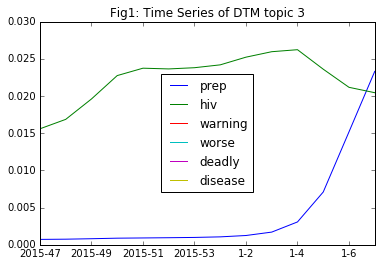

In [8]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=3, time=t_index, topn=1000)
        
    columns = ['prep', 'hiv', 'warning', 'worse', 'deadly', 'disease']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig1: Time Series of DTM topic 3')
fig = ax.get_figure()
fig.savefig('Fig1: Time Series of DTM topic 3.pdf', format='pdf')

# Table 2: top 10 words associated with topic ID 8 over time
Note how at time points 2 and 3 we get world AIDS day related words. At time points 7, 8 and 9 the antibiotic 'Zithromax' appears, then disappears. 'gay' also seems to come up during the later time points, which parallels the #egaylity in the Doc2Vec results. 'rt' is not entirely interesting, since it is the name of a news agency.

In [9]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=8, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability          Word
0     0.053920            rt
1     0.052513           hiv
2     0.025866          it's
3     0.017300        people
4     0.017219        thinks
5     0.015956           amp
6     0.015332          aids
7     0.013636       testing
8     0.009694  worldaidsday
9     0.007301       hivaids

--- time slice:  1 

   Probability          Word
0     0.054567           hiv
1     0.053912            rt
2     0.021688          it's
3     0.017291          aids
4     0.016391        people
5     0.016173           amp
6     0.014525        thinks
7     0.012142       testing
8     0.010977  worldaidsday
9     0.008723       hivaids

--- time slice:  2 

   Probability          Word
0     0.057563           hiv
1     0.052553            rt
2     0.021638          aids
3     0.016234           amp
4     0.014601          it's
5     0.014276        people
6     0.013831  worldaidsday
7     0.012367       hivaids
8     0.009909        thinks
9     0

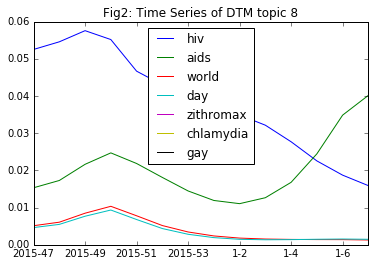

In [10]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=8, time=t_index, topn=1000)
        
    columns = ['hiv', 'aids', 'world', 'day', 'zithromax', 'chlamydia', 'gay']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)


df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig2: Time Series of DTM topic 8')
fig = ax.get_figure()
fig.savefig('Fig2: Time Series of DTM topic 8.pdf', format='pdf')